In [34]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas  as pd
import numpy as np
from enum import Enum

In [128]:
class Datasets(Enum):
    PPI = 1
    
DATASET_TO_USED = Datasets.PPI

def get_ppi_dataset(emb_file):
    """
    returns a dataframe with embeddings and labels
    """
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    lines = [line for line in open(LABELS_FILE).read().splitlines()]
    node_ids = [int(line.split()[0]) for line in lines]
    labels = [list(map(int, line.split()[1:])) for line in lines]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

# TODO: REMOVE IT IF IT'S NOT USED LATER, it was used for blogcatalog dataset. 
# Could be used for other datasets as well if they have same format
def get_blog_dataset():
    # first row has the # of nodes and features
    emb_df = pd.read_csv(EMB_FILE, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    input_df = pd.read_csv(INPUT_FILE, header=None, names=["node_id", "label"])
    input_df_grouped = input_df.groupby(by=['node_id'])['label'].apply(list).reset_index(name ='labels')
    result_df = pd.merge(emb_df, input_df_grouped, on='node_id', how='inner')
    
    return result_df


if DATASET_TO_USED == Datasets.PPI:
    LABELS_FILE = "../data/PPI/ppi_labels.txt"
    emb_file = "../emb/ppi.emb"
    INPUT_FILE = "../data/PPI/ppi.edgelist"
    df = get_ppi_dataset(emb_file)

In [36]:
# Extend prediction function for the OVR logistic regression model
# This code is taken from https://github.com/Kombustor/submission-ecir2020-randomwalks/blob/submission/impl/model/classify.py#L11
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        """
        return the labels with the highest k probabilities prediction, where k is the number of labels Y_test have
        """
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)

[21.26032425818293]
[21.26032425818293]


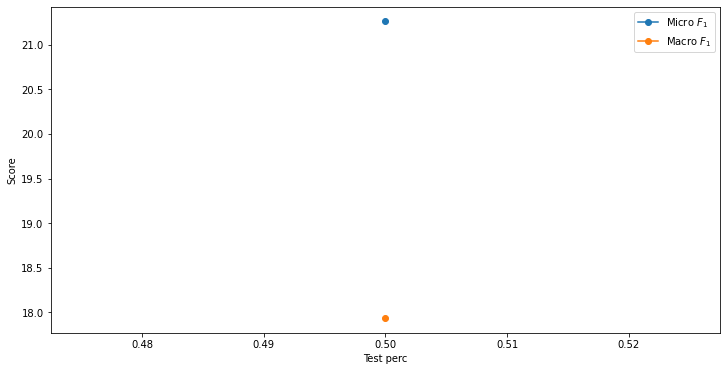

In [45]:
def evaluate(df, test_sizes, num_iter=10):
    evaluations_micro = []
    evaluations_macro = []

    Y = df['labels']
    X = df.drop(columns=['labels', 'node_id'])

    # binarize data
    binarizer = MultiLabelBinarizer()
    binarizer.fit(Y)

    # Linear regression uses L2 regularization by default
    ovr_lr =  OneVsRestClassifier(lr(solver='liblinear'))
    clf = TopKRanker(ovr_lr)

    for test_size in test_sizes:
        micro_scores = []
        macro_scores = []
        for x in range(num_iter):

            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

            Y_train = binarizer.transform(Y_train)

            top_k_list = [len(l) for l in Y_test]
            Y_test = binarizer.transform(Y_test)

            # evaluation
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test, top_k_list=top_k_list)

            micro_scores.append(f1_score(Y_test, Y_pred, average='micro', zero_division=0))
            macro_scores.append(f1_score(Y_test, Y_pred, average='macro', zero_division=0))
        
        evaluations_micro.append(sum(micro_scores)/num_iter*100)
        evaluations_macro.append(sum(macro_scores)/num_iter*100)
        print(f"Perc: {test_size}")
    return evaluations_micro, evaluations_macro

def plot_scores(micro, macro, test_size):
    fig, ax = plt.subplots(figsize=(12, 6))

    micro.reverse()
    macro.reverse()
    
    plt.plot(test_size, micro, marker='o', label='Micro $F_1$')
    plt.plot(test_size, macro, marker='o', label='Macro $F_1$')
        
    plt.xlabel("Test perc")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.show()

Perc: 0.5


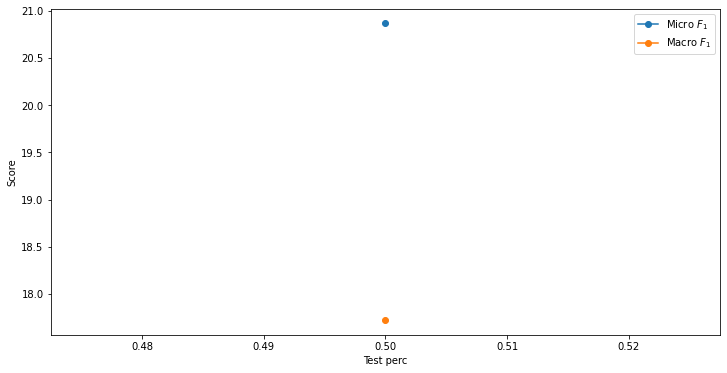

In [46]:
test_size_exp =  [x/10 for x in range(1, 10)]
micro, macro = evaluate(df, test_size_exp, 1)
plot_scores(micro, macro, test_size_exp)

# Grid search for q and p

In [129]:
import subprocess

grid = {
    'q': [0.25, 0.50, 1, 2, 4],
    'p': [0.25, 0.50, 1, 2, 4]
}

evaluations = []

for p in grid['p']:
    for q in grid['q']:
        print(f"p: {p} q: {q}")
        emb_file =  f"{DATASET_TO_USE}_q_{q}_p_{p}.emb"

        if DATASET_TO_USED == Datasets.PPI:
            cmd = f"python main.py --p {p} --q {q} --input {INPUT_FILE} --output {emb_file} --weighted "

        subprocess.run(cmd, shell=True)
        
        if DATASET_TO_USED == Datasets.PPI:
            df = get_ppi_dataset(emb_file)
            
        micro, macro = evaluate(df, [0.5])
        
        evaluations.append((q, p, micro, macro))

p: 0.25 q: 0.25


Preprocessing Nodes: : 0it [00:00, ?it/s]
Preprocessing Nodes: : 0it [00:00, ?it/s]

Preprocessing Edges: 100%|██████████| 3890/3890 [00:00<00:00, 24564.99it/s]


Loading graph
Graph with 3890 nodes and 38739 edges
Preprocessing transition probabilities


 20%|██        | 7887/38739 [00:05<00:25, 1195.49it/s]Traceback (most recent call last):
  File "/home/yasser/university/data_mining/mini_project/node2vec/src/main.py", line 139, in <module>
    main(args)
  File "/home/yasser/university/data_mining/mini_project/node2vec/src/main.py", line 129, in main
    G.preprocess_transition_probs()
  File "/home/yasser/university/data_mining/mini_project/node2vec/src/node2vec.py", line 124, in preprocess_transition_probs
    alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
  File "/home/yasser/university/data_mining/mini_project/node2vec/src/node2vec.py", line 91, in get_alias_edge
    unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
KeyboardInterrupt
 21%|██        | 7978/38739 [00:05<00:22, 1350.01it/s]


KeyboardInterrupt: 

In [127]:
# Max micro and macro 
micro = [x[2][0] for x in evaluations]
macro = [x[3][0] for x in evaluations]

max_micro_index = micro.index(max(micro))
max_macro_index = macro.index(max(macro))

print(evaluations[max_micro_index])
print(evaluations[max_macro_index])

(0.5, 2, [21.68730072194998], [18.59494661406493])
(2, 1, [21.54291027637793], [18.61142173159711])


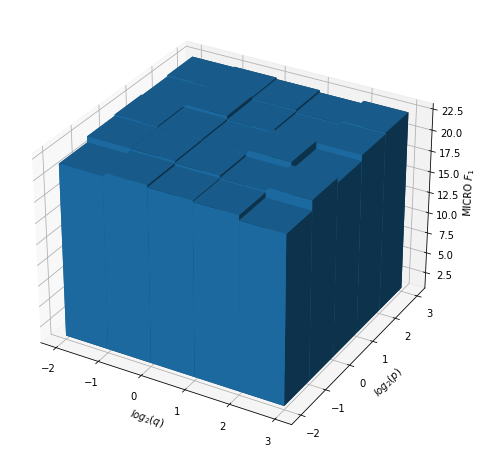

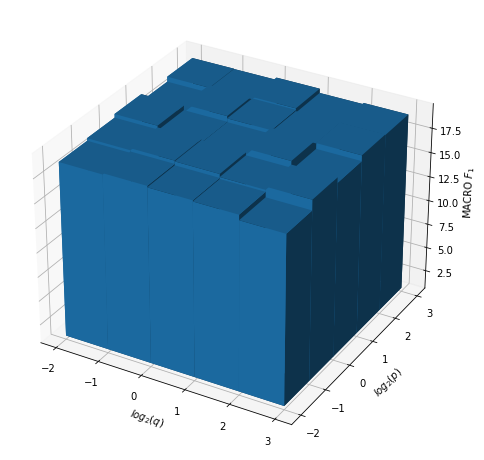

In [126]:
class Scores(Enum):
    MACRO = 1
    MICRO = 2
    
q = [np.log2(x[0]) for x in evaluations]
p = [np.log2(x[1]) for x in evaluations]
micro = [x[2][0] for x in evaluations]
macro = [x[3][0] for x in evaluations]

def plot_grid(p, q, scores, score_enum):
    q = np.array(q)
    p = np.array(p)
    scores = np.array(scores)
    
    if score_enum == Scores.MICRO:
        file_name =  "micro_score"
        label = "MICRO $F_1$"
    elif score_enum == Scores.MACRO:
        file_name =  "macro_score"
        label = "MACRO $F_1$"

    fig = plt.figure(figsize=(8, 16))
    ax = fig.add_subplot(111, projection='3d')

    ax.bar3d(q, p, np.ones(len(scores)),
              1, 1, scores)

    ax.set_xlabel('$log_2(q)$')
    ax.set_ylabel('$log_2(p)$')
    ax.set_zlabel(label)
    plt.savefig(f"../images/classification/{file_name}_{DATASET_TO_USE}", dpi=300)

plot_grid(p, q, micro, Scores.MICRO)
plot_grid(p, q, macro, Scores.MACRO)